# 

# Focused on indervidual events

Looking at single events, drawn from the G4 data, and produced by a model.

Viewing events produced by the model is mostly a sanity check.

While looking at the G4 data a common need is to check for anomalous data. This is done with the help pf functions in `pointcloud.utils.clean_data`.

## Start with imports and configs

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from pointcloud.config_varients.wish import Configs
from pointcloud.config_varients.wish_maxwell import Configs as MaxwellConfigs
from pointcloud.config_varients.default import Configs as DefaultConfigs

from pointcloud.data.read_write import read_raw_regaxes, get_n_events
#from pointcloud.utils.clean_data import mask_showerless

import os

def try_mkdir(dir_name):
    try:
        os.mkdir(dir_name)
    except FileExistsError:
        pass


from visulise_data import plot_data_iteration
#%matplotlib widget


%run visulise_data.py
configs = MaxwellConfigs()
defaults = DefaultConfigs()
configs.poly_degree = 1
#configs.dataset_path_in_storage = False
#configs.dataset_path = "../../../point-cloud-diffusion-data/even_batch_10k.h5"
#configs.dataset_path = "../../../data_production/ILCsoftEvents/p22_r0_th90_ph90_en10-90_downsampled.h5"
#configs.dataset_path = "/home/dayhallh/Data/p22_th90_ph90_en10-100_joined/p22_th90_ph90_en10-100_seed42_all_steps.hdf5"
#configs.dataset_path_in_storage = True
#configs._dataset_path = defaults._dataset_path

Grab some random events and plot one with a function from elsewhere.

((1000,), (1000, 60000, 4))


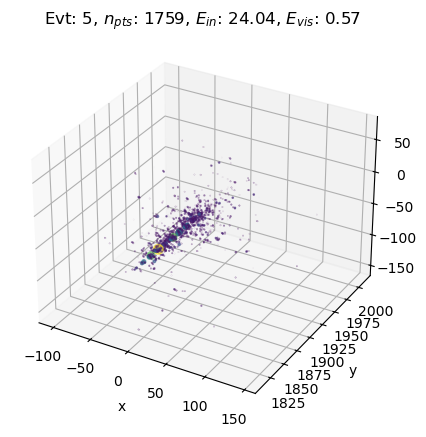

In [18]:
energies, events = read_raw_regaxes(configs, list(range(0, 1000)))
print((energies.shape, events.shape))
plot_data_iteration(events, energies, event_n=5)


In [19]:


def plot_event(event_n, energy_in, use_event, energy_scale=1, x_scale=1):
    energy = use_event[:, 3]
    mask = energy>0
    n_points = sum(mask)
    energy = energy[mask] * energy_scale
    xs = use_event[mask, 0] * x_scale
    ys = use_event[mask, 1] * x_scale
    zs = use_event[mask, 2] 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, c=energy, s=energy, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(-150, 150)
    ax.set_ylim(-150, 150)
    # write a title
    observed_energy = energy.sum()
    ax.set_title(f'Evt: {event_n}, $n_{{pts}}$: {n_points}, $E_{{in}}$: {energy_in:.2f}, $E_{{vis}}$: {observed_energy:.2f}')
    
def plot_model(energy_in, model):
    xs, ys, zs, es = model.inference(energy_in)
    event = np.empty((len(xs), 4))
    event[:, 0] = xs
    event[:, 1] = ys
    event[:, 2] = zs
    event[:, 3] = es
    plot_event("Modeled", energy_in, event, energy_scale=1., x_scale=150)


### G4

Quickly plot a few G4 events. Shows some expected behavior.

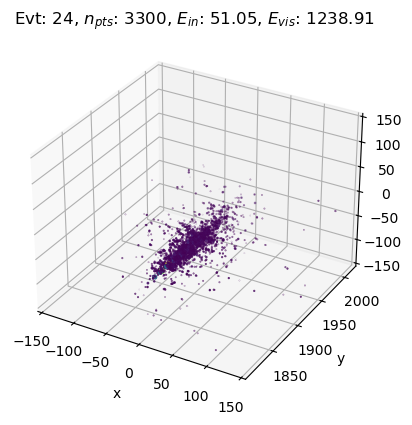

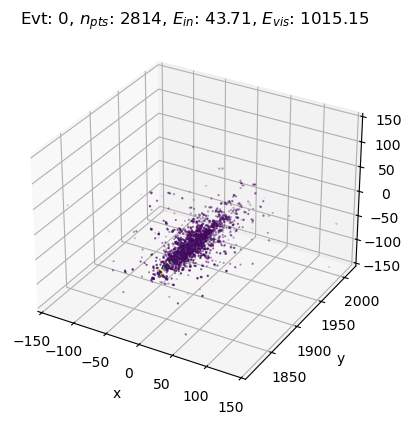

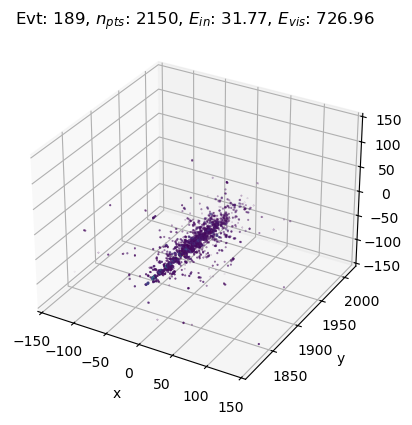

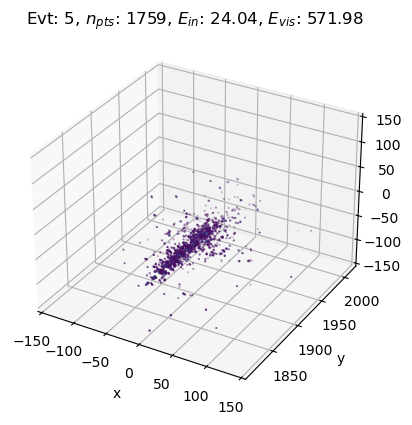

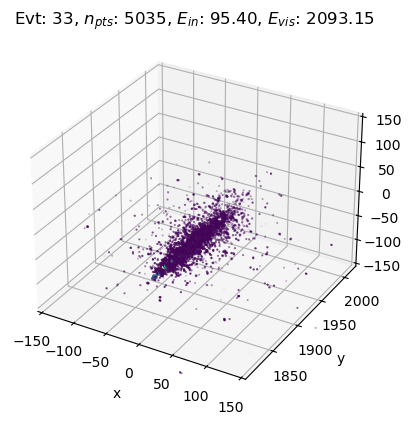

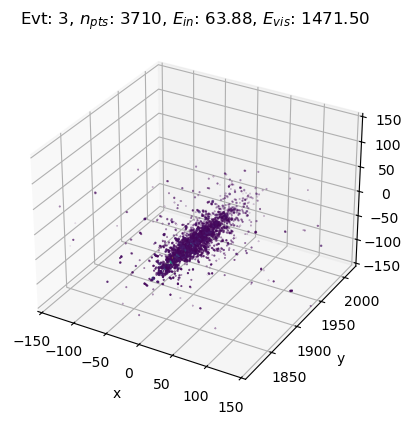

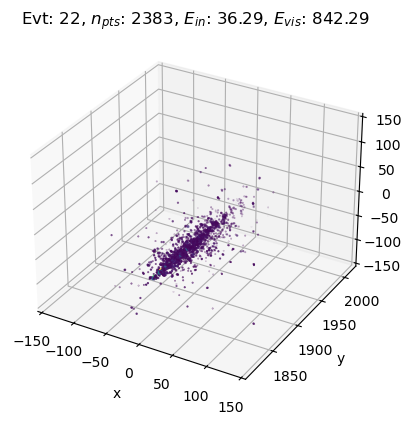

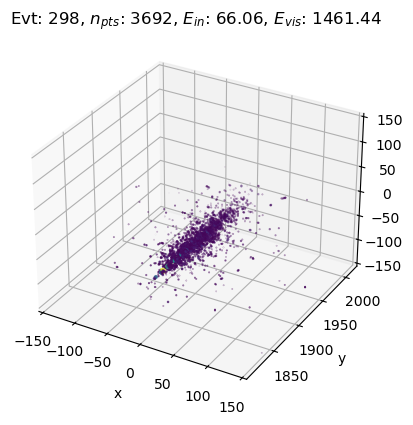

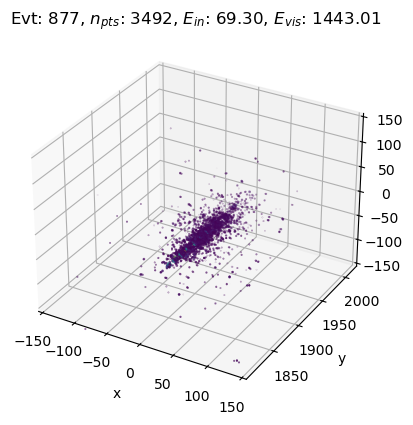

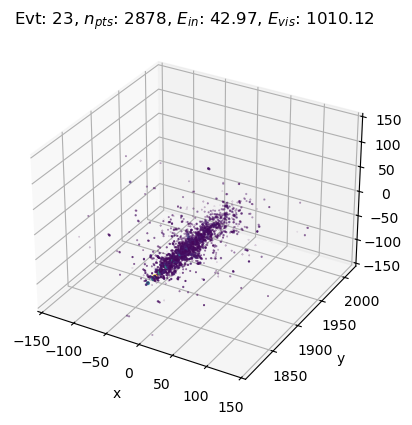

In [20]:
# high anomaly
#for event_n in [0, 2, 15, 98]:
for event_n in [ 24,   0, 189,   5,  33,   3,  22, 298, 877,  23 ]:
    # make a 3d plot of the x, y, z points in the events array
    
    energy_in = energies[event_n]
    use_event = events[event_n]
    plot_event(event_n, energy_in, use_event, energy_scale=1000)


### Wish

Plot those same energies from the model.

In [21]:
from pointcloud.models.wish import Wish, load_wish_from_accumulator


#wish_path = "../../../point-cloud-diffusion-logs/wish/dataset_accumulators/10-90GeV_x36_grid_regular_524k_float32/wish_from_10.pt"
wish_path = "../../../point-cloud-diffusion-logs/wish/dataset_accumulators/p22_th90_ph90_en10-1/wish_poly1.pt"
accumulator_path = "../../../point-cloud-diffusion-logs/wish/dataset_accumulators/p22_th90_ph90_en10-100_accumulator.h5"
# acaccumulator_path = "../../../point-cloud-diffusion-logs/wish/dataset_accumulators/10-90GeV_x36_grid_regular_524k_float32/from_10_0p25.h5"


wish_model = Wish(configs)
#wish_model = load_wish_from_accumulator(accumulator_path)
#wish_model.save(wish_path)
wish_model = Wish.load(wish_path)

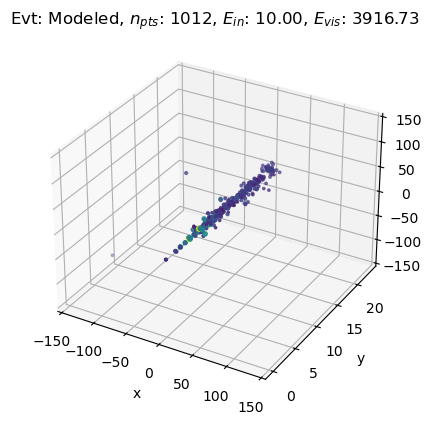

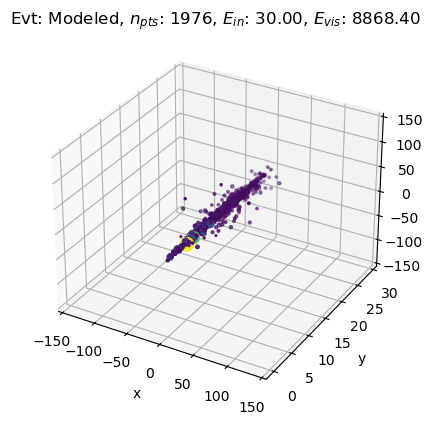

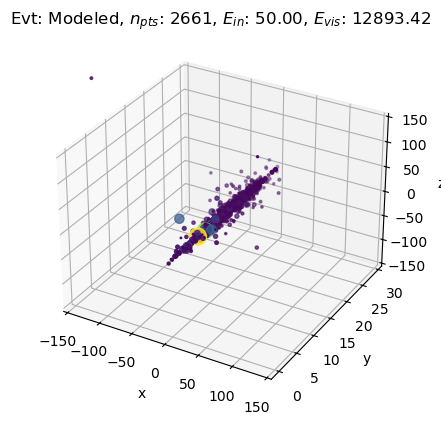

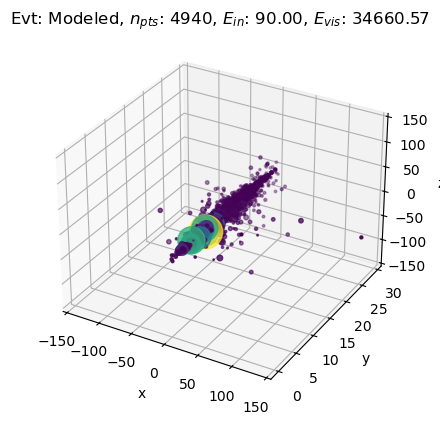

In [22]:
for e in [10, 30, 50, 90]:
    plot_model(e, wish_model)

## Find anomaly limits

Trying to create a range of images that would allow finding the limits of when the data becomes non-showers.

# MIP peak

Quick look at the energy spectrum, investigating the MIP peak.

In [23]:
energies, events = read_raw_regaxes(configs, total_size=2000)

Selecting evenly spaced events


[]

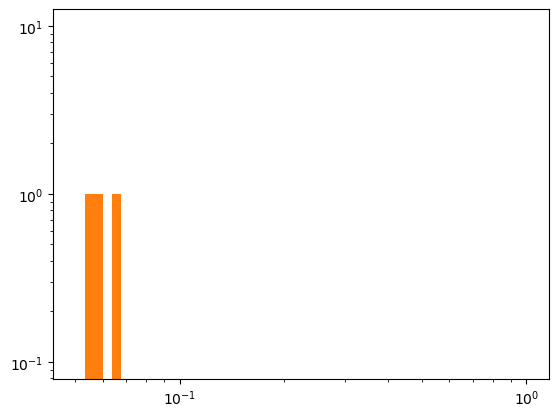

In [24]:
energies = events[:, :, 3].flatten()
mask = energies>0
log_x = True
n_bins = 50
if log_x:
    bins = np.logspace(np.log10(0.05), np.log10(1.), n_bins)
else:
    bins = n_bins
mip_max = 0.25
mip_energies = energies<mip_max * mask
non_mip_energies = energies>mip_max * mask
plt.hist(energies[mask], bins=bins)
plt.hist(energies[mip_energies], bins=bins)
if log_x:
    plt.semilogx()
plt.semilogy()